# Lorenz-System

Ein Projekt im Rahmen der VU "Numerische Methoden für Differentialgleichungen"

von Clemens Eckl, Johannes Zischg, Emil Becker und Maximilian Stollmayer

## Einleitung

Edward N. Lorenz (1917-2008), ein Meteorologe am MIT, vereinfachte 1963 ein Wettermodell basierend auf den Navier-Stokes-Gleichungen zu einem idealisierten hydrodynamischen System von nur mehr 3 Gleichungen, um das Langzeitverhalten der Atmosphäre zu studieren:

\begin{cases}
    \dfrac{\mathrm{d} x}{\mathrm{d} t} = \sigma (y - x) \\
    \dfrac{\mathrm{d} y}{\mathrm{d} t} = x (\rho - z) - y \\
    \dfrac{\mathrm{d} z}{\mathrm{d} t} = x y - \beta z
\end{cases}

Dieses System beschreibt eine Idealisierung einer zwei-dimensionalen Flüssigkeit, die von unten gewärmt und von oben gekühlt wird. Dabei ist $x$ proportional zur Konvektionsrate und $y$ bzw. $z$ zum horizontalen bzw. vertikalen Temperaturunterschied. Die Konstanten $\sigma$, $\rho$ und $\beta$ können mit der [Prandtl-Zahl](https://de.wikipedia.org/wiki/Prandtl-Zahl), der [Rayleigh-Zahl](https://de.wikipedia.org/wiki/Rayleigh-Zahl) und anderen physikalischen Dimensionen in Verbindung gebracht werden.

Wie wir sehen werden und wie auch Edward Lorenz erkannte, ist dieses System sehr sensitiv gegenüber Änderungen der Anfangsbedingungen. In seinem Vortrag _"Predictability: Does the Flap of a Butterfly's Wings in Brazil Set Off a Tornado in Texas?"_ beschrieb er dieses Phänomen mit jener einprägsamen Metapher, die nun als Schmetterlingseffekt bzw. _butterfly effect_ bekannt ist. Dieser Effekt ist ein grundlegendes Prinzip aus der Chaostheorie und wurde vielfach in Literatur, Filmen und Videospielen verarbeitet. Das sogenannte deterministische Chaos mit dem sich die Chaostheorie beschäftigt, hat Edward Lorenz in folgendem Satz geschickt zusammengefasst:

_<center>Chaos: When the present determines the future, but the approximate present does not approximately determine the future.</center>_

## Numerische Analyse

_Emil_

## Numerische Simulation

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))


def LorenzSystem(sigma, rho, beta):
    def ODE(t, state):
        x, y, z = state
        return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
    return ODE


def ParametricPlot(*args, labels=None, title=""):
        
    fig = plt.figure()
    ax = fig.gca(projection="3d")

    ax.w_xaxis.pane.set_color("w")
    ax.w_yaxis.pane.set_color("w")
    ax.w_zaxis.pane.set_color("w")
    ax.set_xlabel("x Axis")
    ax.set_ylabel("y Axis")
    ax.set_zlabel("z Axis")
    ax.set_title(f"{title}", pad=16)

    for i, states in enumerate(args):
        if labels is None:
            ax.plot(*states.T, linewidth=0.5, alpha=0.95)
        else:
            ax.plot(*states.T, linewidth=0.5, alpha=0.95, label=f"{labels[i]}")

    if labels is not None:
        plt.legend()
    plt.show()

    
def Plot(t, *args, labels=None, title="", sameAxis=True):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(3, 1, 1, xticklabels=[])
    ax2 = fig.add_subplot(3, 1, 2, xticklabels=[])
    ax3 = fig.add_subplot(3, 1, 3)

    ax1.set_title(f"{title}", pad=24)
    ax1.set_ylabel("x Axis")
    ax2.set_ylabel("y Axis")
    ax3.set_ylabel("z Axis")
    ax3.set_xlabel("time")
    
    
    if sameAxis:
        for i, states in enumerate(args):
            if labels is None:
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=1, alpha=0.95)
            else:
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=1, alpha=0.95, label=f"{labels[i]}")
            ax2.plot(t, states.T[1], color=f"C{i}", linewidth=1, alpha=0.95)
            ax3.plot(t, states.T[2], color=f"C{i}", linewidth=1, alpha=0.95)
    
    else:
        for i, states in enumerate(args):
            if labels is None:
                ax1.plot(t[i], states.T[0], color=f"C{i}", linewidth=1, alpha=0.95)
            else:
                ax1.plot(t[i], states.T[0], color=f"C{i}", linewidth=1, alpha=0.95, label=f"{labels[i]}")
            ax2.plot(t[i], states.T[1], color=f"C{i}", linewidth=1, alpha=0.95)
            ax3.plot(t[i], states.T[2], color=f"C{i}", linewidth=1, alpha=0.95)
    
    if labels is not None:
        ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=len(args), mode="expand", borderaxespad=0)
    plt.show()

### Euler-Methode

_Clemens_

MATLAB Code test
```octave
tx = linspace (-8, 8, 41);
ty = tx;
[xx, yy] = meshgrid (tx, ty);
r = sqrt (xx .^ 2 + yy .^ 2) + eps;
tz = sin (r) ./ r;
```

### Runge-Kutte 4

Beim Runge-Kutta Verfahren handelt es sich um ein (meist) explizites Einschrittverfahren, dass eine hohe Konvergenzordnung besitzt. Die Idee ist, durch die Einführung von Zwischenschritten das Integral in der Lösung des Anfangswertproblems auf einem Teilintervall $[t_n,t_{n+1}]$ durch eine Quadraturformel zu ersetzen, die an diesen Zwischenschritten ausgewertet wird:

$$y(t_{n+1}) = y(t_n)+\int_{t_n}^{t_{n+1}}f(\tau,y(\tau))d\tau$$ mit $$\int f(\tau)d\tau \sim \sum_{j=1}^{v}b_j f(c_j)$$

Dabei stellen die $b_j$ Gewichte und die $c_j$ Knoten dar. Durch die Berechnung der vorherigen Knoten der Quadratur erhält man die Auswertung von $y$ an einem bestimmten Punkt. Daraus kann nun ein explizites Verfahren mit folgendem Verfahrensschritt konstruiert werden:

explizites Verfahren:
\begin{align*}
    \epsilon_1 &= y_n \\
    \epsilon_2 &= y_n + a_{21}hf(t_n,\epsilon_1) \\
    \epsilon_3 &= y_n + a_{31}hf(t_n,\epsilon_1)+a_{32}hf(t_n+c_2h,\epsilon_2) \\
    & \qquad \vdots \\
    \epsilon_v &= y_n+h\sum_{j=1}^{v-1}a_{vj}f(t_n+c_jh,\epsilon_j)
\end{align*}

Verfahrensschritt:
$$y_{n+1} = y_n + h\sum_{j=1}^{v}b_jf(t_n+c_jh,\epsilon_j)$$

Die Koeffizienten dieses Verfahrens werden in einer Tabelle, gennant Butcher-Tableau, gesammelt:

<table>
<tbody>
  <tr style="background-color: white;">
    <td>$c_1$</td>
    <td>$a_{11}$</td>
    <td>$\dots$</td>
    <td>$a_{1i}$</td>
  </tr>
  <tr>
    <td>$c_2$</td>
    <td>$a_{21}$</td>
    <td>$\dots$</td>
    <td>$a_{2i}$</td>
  </tr>
  <tr style="background-color: white;">
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\dots$</td>
    <td>$\vdots$</td>
  </tr>
  <tr>
    <td>$c_i$</td>
    <td>$a_{i1}$</td>
    <td>$\dots$</td>
    <td>$a_{ii}$</td>
  </tr>
</tbody>
<tfoot style="border-top: 1px solid black;">
  <tr>
    <td></td>
    <td>$b_1$</td>
    <td>$\dots$</td>
    <td>$b_i$</td>
  </tr>
</tfoot>
</table>

Damit das Verfahren explizit ist, darf jedes $\epsilon_i$ nur von den vorhergehenden Zwischenschritten abhängen. Das bedeutet, dass die Matrix A eine untere Dreiecksmatrix sein muss.

Für das Runge Kutta Verfahren 4. Ordnung ergibt sich so etwa folgende Matrix:

<table>
<tbody>
  <tr style="background-color: white;">
    <td>$0$</td>
    <td>$0$</td>
    <td>$0$</td>
    <td>$0$</td>
    <td>$0$</td>
  </tr>
  <tr>
    <td>$\frac{1}{2}$</td>
    <td>$\frac{1}{2}$</td>
    <td>$0$</td>
    <td>$0$</td>
    <td>$0$</td>
  </tr>
  <tr style="background-color: white;">
    <td>$\frac{1}{2}$</td>
    <td>$0$</td>
    <td>$\frac{1}{2}$</td>
    <td>$0$</td>
    <td>$0$</td>
  </tr>
  <tr>
    <td>$1$</td>
    <td>$0$</td>
    <td>$0$</td>
    <td>$1$</td>
    <td>$0$</td>
  </tr>
</tbody>
<tfoot style="border-top: 1px solid black;">
  <tr>
    <td></td>
    <td>$\frac{1}{6}$</td>
    <td>$\frac{1}{3}$</td>
    <td>$\frac{1}{3}$</td>
    <td>$\frac{1}{6}$</td>
  </tr>
</tfoot>
</table>

Mit dem Verfahren:
\begin{align*}
    k_1 &= f_n \\
    k_2 &= f(t_n+\frac{h}{2},\, y_n+\frac{h}{2}k_1) \\
    k_3 &= f(t_n+\frac{h}{2},\, y_n+\frac{h}{2}k_2) \\
    k_4 &= f(t_n+h,\, y_n+h \ k_3) \\
\end{align*}

$$y_{n+1} = y_n + \frac{h}{6}(k_1+2k_2+2k_3+k_4)$$

Hierbei handelt es sich (wieder) um ein explizites Verfahren mit Konsistenzordnung 4 ($p=v$)

<em style="color:red;">CODE EINFÜGEN</em>

### Prädiktor-Korrektor-Verfahren

Die Idee des Prädiktor-Korrektor-Verfahrens ist die Kombination von expliziten und impliziten Verfahren um gute Konvergenzeigenschaften zu erhalten, ohne dabei den Rechenleistungspreis der impliziten Verfahren zu zahlen.

Dazu wird als Prädiktor ein Schritt eines expliziten Verfahrens ausgeführt und das Ergebnis in den Korrektor, einer impliziten Gleichung, eingesetzt um kein Gleichungssystem lösen zu müssen.

Bei Einschrittverfahren sieht die Prädiktor-Evaluierung-Korrektor-Evaluierung Schleife wie folgt aus:

\begin{align*}
&(P) \qquad \tilde{y}_{n+1} = y_n + h \ \Phi_P(t_n,\, y_n,\, f_n,\, h) \\
&(E) \qquad \tilde{f}_{n+1} = f(t_{n+1},\, \tilde{y}_{n+1}) \\
&(C) \qquad y_{n+1} = y_n + h \ \Phi_C(t_n,\, y_n,\, \tilde{y}_{n+1},\, f_n,\, \tilde{f}_{n+1},\, h) \\
&(E) \qquad f_{n+1} = f(t_{n+1},\, y_{n+1})
\end{align*}

Wobei hier $\Phi_P$ das explizite und $\Phi_C$ das implizite Einschrittverfahren bezeichnet.

Um die Genauigkeit zu erhöhren, kann man z.B. nun den Korrektor mehrmals anwenden und kommt so zu dem Modus PE(CE)$^k$ bzw. wenn man ihn so oft anwendet bis Konvergenz zu einer gewünschten Toleranz vorliegt: PE(CE)$^\infty$.

Oft verwendete Prädiktor-Korrektor-Verfahren:
- Methode von Heun: explizites Euler-Verfahren als Prädiktor und Crank-Nicolson als Korrektor
- ABM: Adams-Bashforth als Prädiktor und Adams-Moulton als Korrektor

Die Kombination von Adams-Bashforth und Adams-Moulton wurde hier als Mischung aus PE(CE)$^k$ und PE(CE)$^\infty$ implementiert und ein Schritt läuft so ab:

\begin{align*}
&(PE) \qquad \tilde{y}_{n+1} = y_n + h \ \sum_{j=0}^s a_j \ f(t_{n-j},\, y_{n-j}) \\
&(CE) \qquad y_{n+1} = y_n + h \ \sum_{j=0}^{s-1} b_j \ f(t_{n-j},\, y_{n-j}) + h \ b_{-1} \ f(t_{n+1},\, \tilde{y}_{n+1})
\end{align*}

Dabei ist $s$ die Anzahl der Schritte und $(a_j)_{j=0}^s$ sowie $(b_j)_{j=-1}^{s-1}$ die Koeffizienten der Mehrschrittverfahren, die man aus einer Polynominterpolation gewinnt.

(CE) wird hier so oft wiederholt bis die gewünschte Konvergenz oder die vorgegebene Anzahl an Zyklen erreicht ist.

In [5]:
def ABM(f, state0, t, steps=5, iters=1, tol=1e-8):
    '''
    returns array of states solved from the initial state using the predictor-corrector method Adams-Bashforth-Moulton

    f ........ function of the ODE: y' = f(t, y)
    state0 ... initial state vector [state0_1, state0_2, ...]
    t ........ discretized time interval [t0, t1, ...]
    steps .... number of interpolation steps per time step
    iters .... number of iterations for each correction-evaluation cycle
    tol ...... if this tolerance is met the correction-evaluation cycle breaks
    '''
    
    # input processing
    state0 = np.array(state0)
    s = steps if 0 < steps < 5 else 5
    iters = int(iters) if 0 < iters else 1
    N = len(t)
    h = (t[-1] - t[0]) / N

    # initialize state array with initial state
    states = np.zeros((N, 3))
    states[0] = state0

    # initialize ODE function values
    fvals = np.zeros((N, 3))
    fvals[0] = f(t[0], state0)

    # coefficients for Adams-Bashforth method
    coeffsAB = (1,
                [-1/2, 3/2],
                [5/12, -16/12, 23/12],
                [-9/24, 37/24, -59/24, 55/24],
                [251/720, -1274/720, 2616/720, -2774/720, 1901/720])

    # coefficients for Adams-Moulton method
    coeffsAM = (1,
                [1/2, 1/2],
                [-1/12, 2/3, 5/12],
                [1/24, -5/24, 19/24, 9/24],
                [-19/720, 106/720, -264/720, 646/720, 251/720])

    # increasing steps until desired order is reached
    for n in range(s):
        # predictor: Adams-Bashforth method
        states[n+1] = states[n] + h * np.dot(coeffsAB[n], fvals[:n+1])

        # evaluation
        fvals[n+1] = f(t[n+1], states[n+1])

        # correction-evaluation cycle with Adams-Moulton
        for _ in range(iters):
            new = states[n] + h * np.dot(coeffsAM[n], fvals[:n+1])
            cond = np.allclose(states[n+1], new, atol=tol)
            states[n+1] = new
            fvals[n+1] = f(t[n+1], states[n+1])
            if cond:
                break

    # main loop
    for n in range(s, N-1):
        # predictor: Adams-Bashforth method
        states[n+1] = states[n] + h * np.dot(coeffsAB[s-1], fvals[n-s+1:n+1])

        # evaluation
        fvals[n+1] = f(t[n+1], states[n+1])

        # correction-evaluation cycle with Adams-Moulton
        for _ in range(iters):
            new = states[n] + h * np.dot(coeffsAM[s-1], fvals[n-s+2:n+2])
            cond = np.allclose(new, states[n+1], atol=tol)
            states[n+1] = new
            fvals[n+1] = f(t[n+1], states[n+1])
            if cond:
                break

    return states

### Beobachtungen

#### Schrittweitensensitivität

Für die Parameter $\sigma = 10$, $\rho = 28$ und $\beta = \frac{8}{3}$ wurde bei der Veränderung der Schrittweite folgendes erkennbar:

Die Qualität der Berechnung hängt massiv von der Schrittweite ab, mit Schrittweite $1$ etwa ist überhaupt nichts sinnvolles erkennbar.

Selbiges lässt sich mit einer Schrittweite von $\frac{1}{10}$ beobachten.

Ab einer Schrittweite von $\frac{1}{32}$ ergibt sich langsam die zu erwartende Form.

Mit immer kleinerer Schrittweite nähert sich das Resultat einem bestimmten Zustand an, ersichtlich hier etwa mit den Schrittweiten $\frac{1}{100}$, $\frac{1}{200}$, $\frac{1}{500}$, $\frac{1}{1000}$ und $\frac{1}{10000}$:

In [19]:
sigma = 10
rho = 28
beta = 8/3

f = LorenzSystem(sigma, rho, beta)

state0 = (1, 1, 1)

t1 = np.arange(0, 50, 1/100)
t2 = np.arange(0, 50, 1/200)

statesPC1 = ABM(f, state0, t1)
statesPC2 = ABM(f, state0, t2)

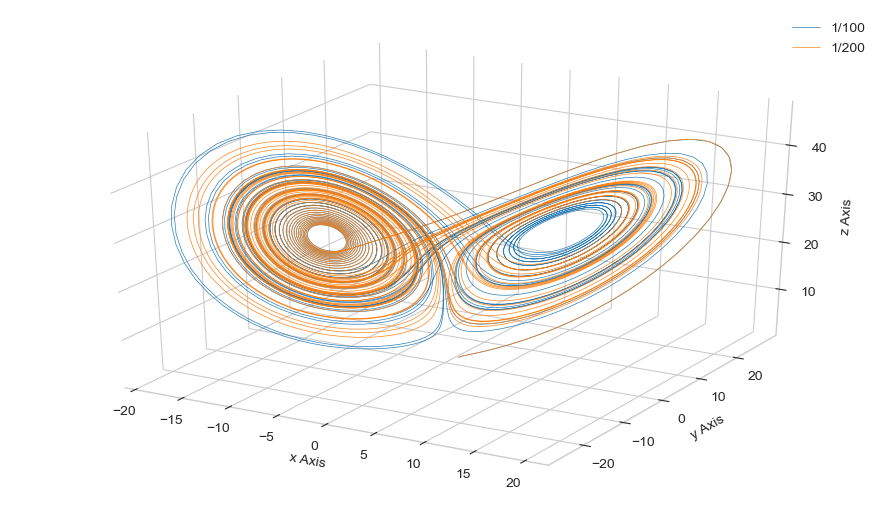

In [20]:
labels=("1/100", "1/200")
ParametricPlot(statesPC1, statesPC2, labels=labels)

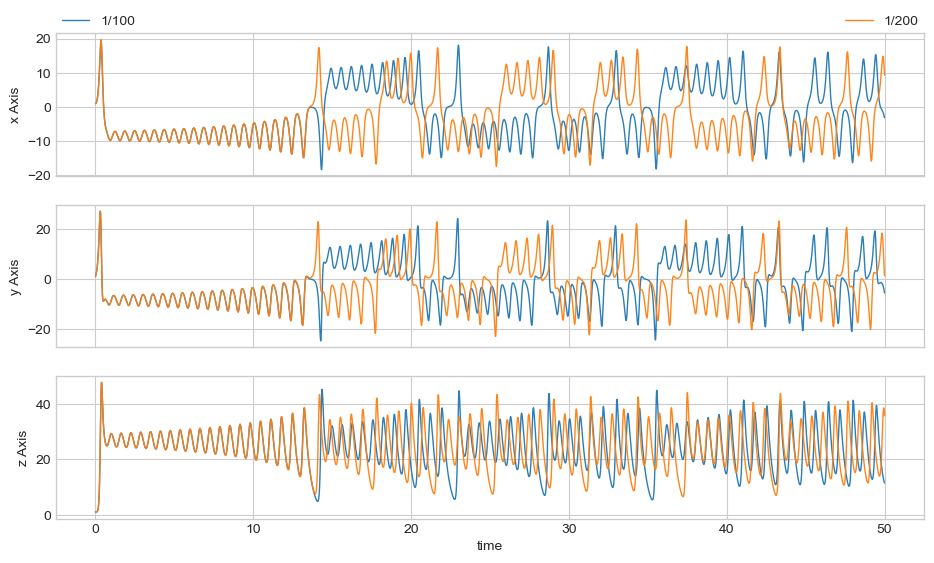

In [28]:
Plot((t1,t2), statesPC1, statesPC2, labels=labels, sameAxis=False)

#### Typisch chaotisches Verhalten

In [11]:
sigma = 10
rho = 28
beta = 8/3

f = LorenzSystem(sigma, rho, beta)

state0 = (1, 1, 1)

t = np.arange(0, 50, 0.01)

statesFE = FE(f, state0, t)
statesRK4 = RK4(f, state0, t)
statesPC = ABM(f, state0, t)

In [ ]:
ParametricPlot(statesFE, statesRK4, statesPC)

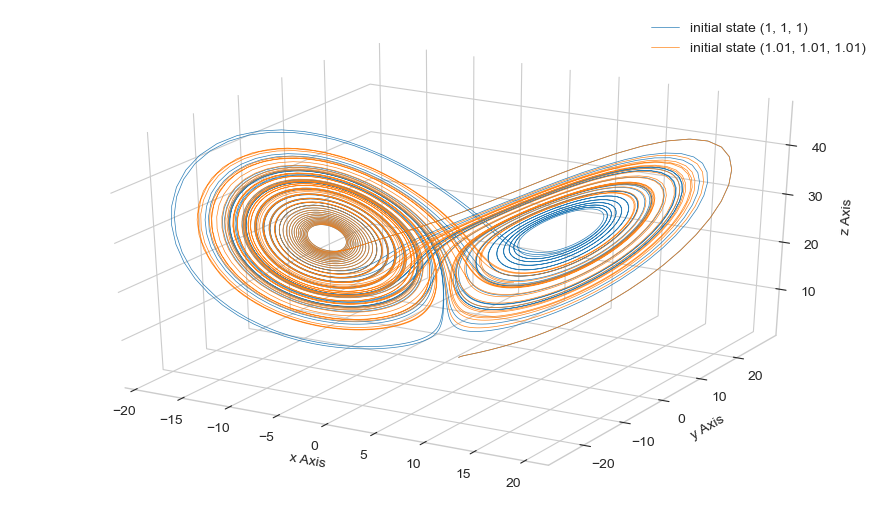

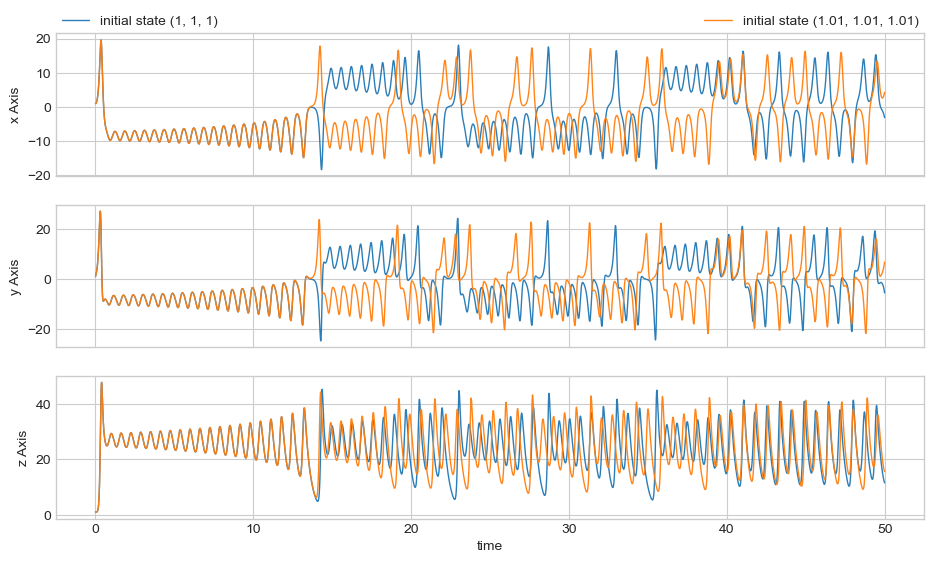

In [12]:
labels = (f"initial state {state1}", f"initial state {state2}")

ParametricPlot(states1, states2, labels=labels)
Plot(t, states1, states2, labels=labels)

In [13]:
%%HTML
<video width="100%" height="auto" controls>
    <source src="Lorenz-System Animation.mp4" type="video/mp4">
</video>

schaut leiwand aus

„bei gleicher Schrittweite ist Euler explizit ganz schlecht, weil…

Runge-Kutte 4 besser aber auch nicht gut, weil …

Prediktor-Korrektor sehr gut, was man daran erkennt…

Wir erklären uns das so: …“

Fixpunkte:
- $p = (0, 0, 0)$
- $q_+ = (\sqrt{\beta(\rho-1)}, \sqrt{\beta(\rho-1)}, \rho-1)$
- $q_- = (-\sqrt{\beta(\rho-1)}, -\sqrt{\beta(\rho-1)}, \rho-1)$

interessante werte für $\rho$ mit $\sigma=10$ und $\beta=\frac{8}{3}$:
- $0 < \rho < 1$: stabil
- $1$: bifurcation
- $13.92655741$ und $13.92655742$
- $28$: typisches chaotisches verhalten
- $144$: 2fache periode
- $167$: chaos -> periodisch -> chaos

### Quellen

[Lorenz-Attraktor, Wikipedia](https://de.wikipedia.org/wiki/Lorenz-Attraktor)

[Deterministic Nonperiodic Flow, Edward N. Lorenz](https://journals.ametsoc.org/jas/article/20/2/130/16956/Deterministic-Nonperiodic-Flow)

[The Lorenz system, James Hateley](http://web.math.ucsb.edu/~jhateley/paper/lorenz.pdf)

[Lorenz-System und seltsame Attraktoren, Andreas Jung](https://andreas.welcomes-you.com/research/talks/lorenz/)

[Predictor-corrector method, Wikipedia](https://en.wikipedia.org/wiki/Predictor–corrector_method)